# Time Series Analysis in Python: Achieving Stationarity

When a given data point depends on that same point's previous values, we say it is time dependent. For example, the closing price of Tesla's stock tomorrow is likely somewhere close to its closing price today. (At the very least, tomorrow's closing price is likely closer to a price this month than five months ago.) 

Given the frequency of time-dependent data, time series forecasting (the applied statistical modeling of predicting future time-dependent values) is a key technique any data analyst and data scientist should possess. Foundational forecasting techniques, like autoregressive and moving average models, rely on one fundamental assumption: stationarity.

In this walkthrough, real world Portland bus ridership data is utilize to introduce how to examine time-dependent data and cause a process to become stationary. We'll discuss what it the basics of time series, means for a process to be stationary, how to apply statistical tests to determine that stationarity, clean data, and make a few plots along the way.

Very basic Python experience is expected; no need for previous time series exposure.

In [1]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/3oz8xKaR836UJOYeOc/giphy.gif">')

# Import necessary libraries

In [2]:
from IPython.display import Image

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# always be stylin'
plt.rcParams['font.size'] = 14
plt.style.use('fivethirtyeight')

# Read and clean the ridership data

This raw data is available both on my [Github](https://raw.githubusercontent.com/josephofiowa/GA-DSI/master/example-lessons/Intro-to-forecasting/portland-oregon-average-monthly-.csv) and at this raw resource, [datamarket](https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line).

In [4]:
bus = pd.read_csv('https://raw.githubusercontent.com/josephofiowa/GA-DSI/master/example-lessons/Intro-to-forecasting/portland-oregon-average-monthly-.csv', index_col=0)


## Inspect the head and the tail

In [5]:
# take a look - data is (a little) dirty
bus.head()

,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
Month,
1960-01,648
1960-02,646
1960-03,639
1960-04,654
1960-05,630


In [6]:
# I spy problems
bus.tail()

,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
Month,
1969-04,1432
1969-05,1394
1969-06,1327
NaN,NaN
Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982,n=114


## Clean the data

In [7]:
# drop the last two indices
bus.drop(bus.tail(2).index, inplace=True)

In [8]:
# convert index into datetime object
bus.index = pd.to_datetime(bus.index)

# name the index "date"
bus.index.name = 'date'

In [9]:
# rename to succinct "riders"
bus.columns = ['riders']

In [10]:
# check it out - it *looks* good, but...
bus.head()

,riders
date,
1960-01-01,648
1960-02-01,646
1960-03-01,639
1960-04-01,654
1960-05-01,630


In [11]:
# . . .check data types
bus.dtypes

riders    object
dtype: object

In [12]:
# convert riders to number and multiple by 100 (original unit in the dataset)
bus.riders = pd.to_numeric(bus.riders)*100

In [13]:
# Voila! 
bus.head()

,riders
date,
1960-01-01,64800
1960-02-01,64600
1960-03-01,63900
1960-04-01,65400
1960-05-01,63000


In [14]:
## optional - export to csv
# bus.to_csv('portland_ridership_cleaned.csv')

# Analysis

As previously noted, time series forecasting relies on achieving stationarity as a bedrock assumption. The purpose of the following analysis is to produce a stationary series ready for forecasting. This is similar to feature preparation for other machine learning techniques.

In a broader sense, this is where our single step lives in the greater time series process:

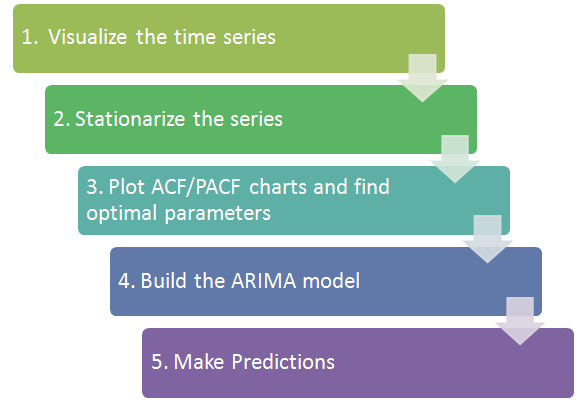

In [15]:
Image('http://www.seanabu.com/img/flowchart.png')

**Step 6: Profit***

**course sold separately*

## Plot the timeseries

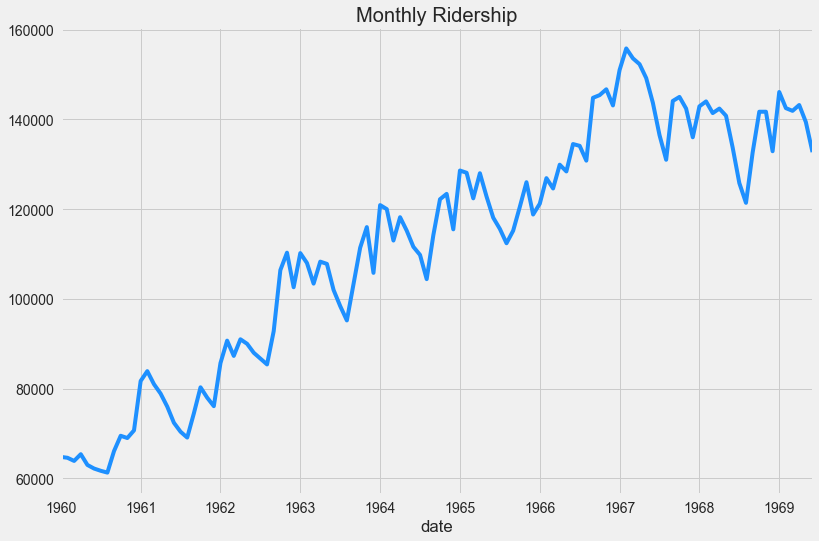

In [16]:
bus.riders.plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14, color='dodgerblue')
# plt.savefig('month_ridership.png', bbox_inches='tight')   # optional save

### Observations: What is notable about this series?

- The number of bus riders in Portland appears to generally be increasing over the observed time period
- There appears to be a vaguely similar annual pattern where ridership increases in colder months and dips in the summer / near beginning of the fall
- Hipsters love the bus
- The deviation from a central trend appears relatively uniform. That is, we likely have nearly constant covariance year-over-year

### What defines stationarity?

A process is stationary when its mean, variance/standard deviation, covariance, and autocorrelation are constantly over time. That **does not** mean we omit the possibility of variation. Quite the opposite: we expect to be variation over time, but we also expect that variation to follow an explanable pattern.

In fun pun terms, stationarity means we have...parked the bus.

In [17]:
HTML('<img src="https://media.giphy.com/media/3o6ZtfluCIZMXwwYwM/giphy.gif">')

A few common factors prevent us from achieve stationarity: increasing means, heteroskedasticity, and non-constant covariance.

### Increasing mean

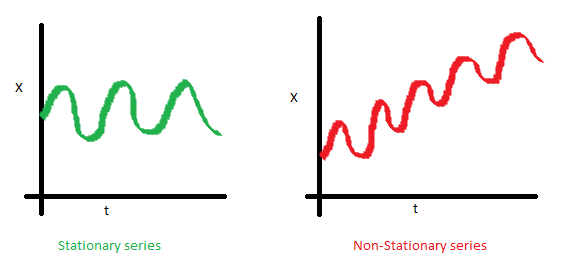

In [18]:
Image('http://www.seanabu.com/img/Mean_nonstationary.png')

### Heteroskedasticity

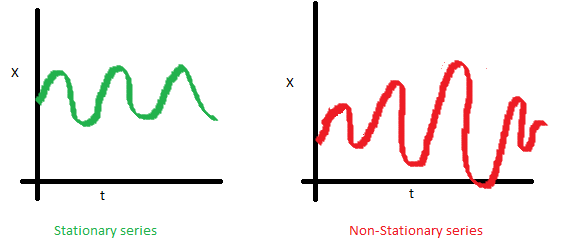

In [19]:
Image('http://www.seanabu.com/img/Var_nonstationary.png')

### Non-constant covariance

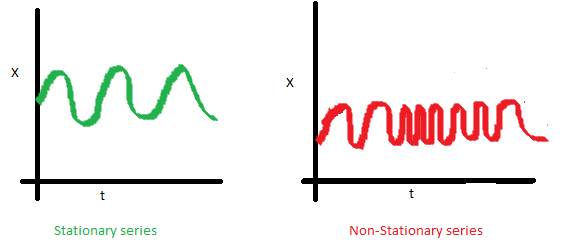

In [20]:
Image('http://www.seanabu.com/img/Cov_nonstationary.png')

Given the above information, safe to say our series does **not** currently appear to be stationary.

### Decompose the series

We can break this series down even further into its component parts: a general mean trend, a seasonal component, and any remaining variations that are not teased out from the prior two forms of decomposition.

This is precisely what seasonal decomposition is. If provided a specific amount of time for a season, can the specific variations be identified?

This relies on us identifying a reasonable seasonal period. We'll assume 12 periods, where, remember, one period is one month in this case.

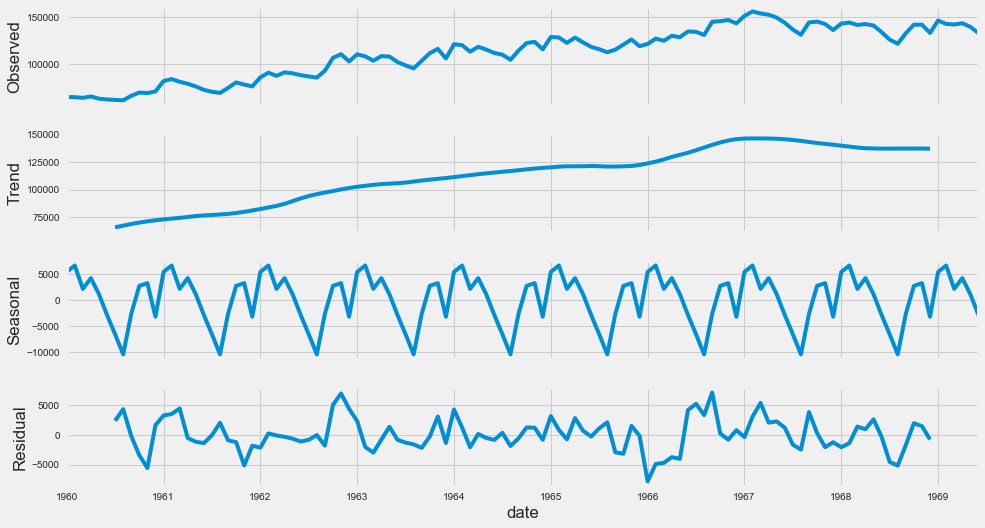

In [21]:
# assume an annual cadence, thus, freq=12
decomposition = seasonal_decompose(bus.riders, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
# plt.savefig('seasonal.png', bbox_inches='tight')   # optional save

### Observations

- The clear increasing mean is problematic for the stationarity of our series
- Assuming a one-year season does assess the ebbs and flows we outlined above: increases in cold months and decreases in warm months
- The residual plot still appears to have some pattern to it. That is, assuming a seasonal trend alone does not explain the full variation in our data. (Recall, identifying and subsequently explaining regular patterns is our goal all along!)

### By the way, you can grab just one of these plots doing the following

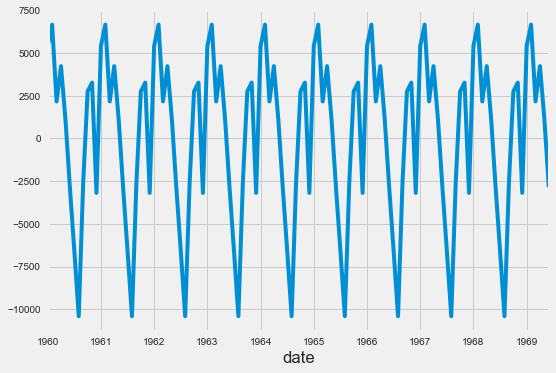

In [22]:
# grab just one graphic doing the following:
seasonal = decomposition.seasonal 
seasonal.plot()

## Statistical Test for Stationarity

In addition to visually examining whether our series *appears* to be stationary, we are also able to apply a statistical test to doing so.

The Augmented Dickey-Fuller test is one such test. The null hypothesis of the Augmented Dickey-Fuller is there is a unit root. (A unit root is a process that, for one reason or another, means our series is not stationary.) The alternative hypothesis is that there is no unit root. If the p-value is above a critical size (typically 0.05), we cannot reject that there is a unit root.

That is:

$H_0: \textrm{Unit root exists. The series is not stationary}$

$H_1: \textrm{We can reject that a unit root exists. The series is stationary}$


$\textrm{Reject } H_0  \textrm{ if p < critical value, typically 0.05}$

More on this in the statsmodels documentation for [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

### Make an Augmented Dickey-Fuller Plotter and Tester Function

In [23]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput 

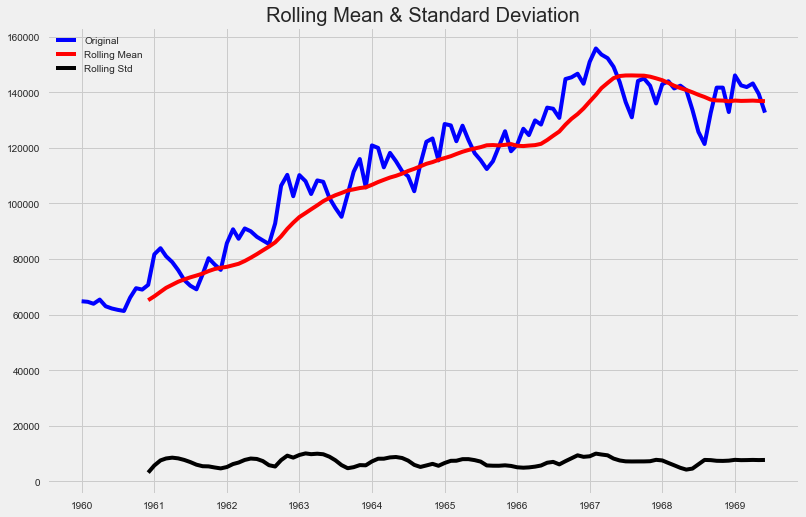

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
Number of Lags Used             12.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [24]:
# perform test on raw data
test_stationarity(bus.riders)

### Interpretation

Because the p-value is greater than 0.05, we cannot reject that a unit root exists. We do not have a stationary process. This is unsurprising: the data without any transformations *appeared* to be non-stationary given the increasing mean and seasonality.

We have not yet parked the bus.

In [25]:
HTML('<img src="https://media.giphy.com/media/13rbvYlDyohGi4/giphy.gif">')

### Differencing, first attempt

To attempt to find stationary, a number of different transformations may be performed on a given dataset. (For a comprehensie dive, I recommend Duke's [time series forecasting transformations breakdown](http://people.duke.edu/~rnau/whatuse.htm).)

In this given case, we're going to perform a straightforward approach: differencing. We will first difference by month. That is, we're going to assume subtracting subsequent months from prior months will detrend our data. This is similar to taking the first derivative with respect to month.

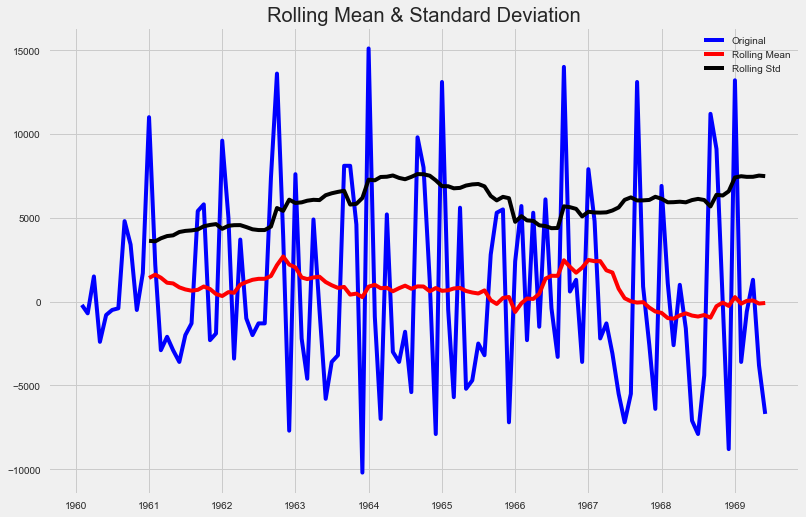

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
Number of Lags Used             11.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [26]:
# first difference and test
bus['first_difference'] = bus.riders - bus.riders.shift(1)  
test_stationarity(bus.first_difference.dropna(inplace=False))

### Interpretation

Given a p-value still greater than 0.05, we have not yet found stationarity in our process.

Closer...

In [27]:
HTML('<img src="https://media.giphy.com/media/tqbPQpkJLSSkM/giphy.gif">')

### Differencing, second attempt

Given we observed a seasonal component (every 12 months) to our data, it is reasonable to difference by this same amount. In doing so, we hope to detrend our data such that we have removed the non-constant standard deviation and increasing mean.

We will try subtracting every period from its period 12 months later, thereby differencing by year.

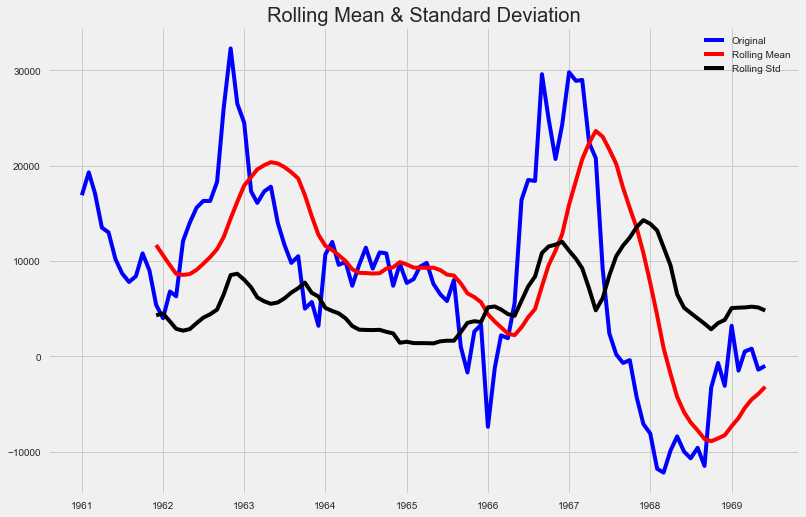

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
Number of Lags Used             3.000000
Number of Observations Used    98.000000
Critical Value (5%)            -2.891516
Critical Value (1%)            -3.498910
Critical Value (10%)           -2.582760
dtype: float64


In [28]:
# seasonal difference
bus['seasonal_difference'] = bus.riders - bus.riders.shift(12)  
test_stationarity(bus.seasonal_difference.dropna(inplace=False))

### Interpretation

Closer, yet our p-value is still greater than 0.05. We cannot reject that a unit root exists in our series. We also see that over the longrun, our mean appears to decrease marginally and large smaller period changes. This informs what we should try next.

Very, very close to a parked bus...

In [29]:
HTML('<img src="https://media.giphy.com/media/kwcd5IRaonsQM/giphy.gif">')

### Differencing, third attempt

Given the month-to-month differencing resolved the mean problem but saw a floating upward standard deviation and our year-to-year differencing saw the opposite, combining the two tactics may be a reasonable choice.

We will take our month-by-month `first_difference` series and take the seasonal difference. That is, our resulting series will be differenced not only by the subsequent month but by that same month in a future year.

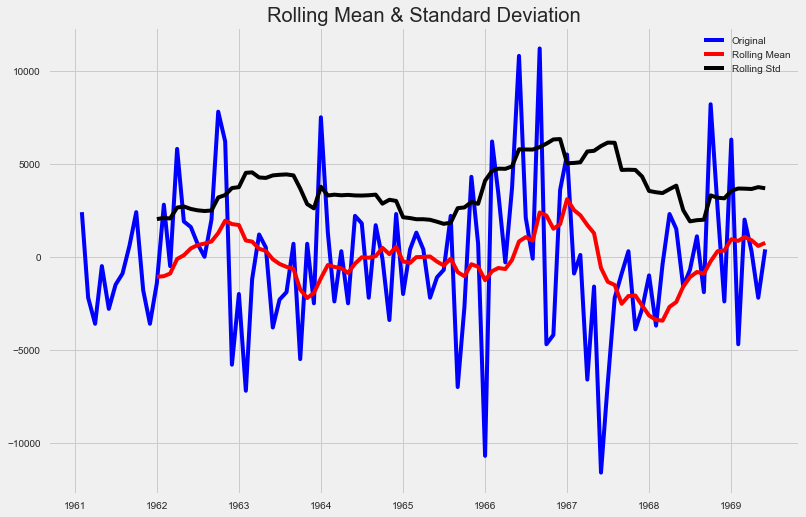

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
Number of Lags Used            0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (5%)           -2.890906e+00
Critical Value (1%)           -3.497501e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [30]:
# month-by-month + seasonal difference
bus['seasonal_first_difference'] = bus.first_difference - bus.first_difference.shift(12)  
test_stationarity(bus.seasonal_first_difference.dropna(inplace=False))

### Interpretation

We've achieved stationariy. The p-value is less than 0.05. In fact, it is less than 0.01. We can reject that a unit root exists in our series and accept the alternative hypothesis that our series is stationary.

In [31]:
HTML('<img src="https://media.giphy.com/media/J1ZajKJKzD0PK/giphy.gif">')

We would then be able to run this model through an autoregressive and/or moving average model to produce predictions of future riding months. To be precise, we would need to use a seasonal ARIMA model (SARIMAX) to difference by two different periods: month-to-month and year-by-year. While those next steps are a bit beyond what is covered here, the statsmodels documentation is a fantastic resource on [SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).

# What's next?

- If you want to learn more about time series, visit the resources I've linked below.
- Check out [General Assembly](https://generalassemb.ly/education/data-science-immersive?utm_medium=social&utm_source=blog&utm_campaign=josephdsi) for in-person and online data science learning
- [Signup for Entropy](https://www.josephofiowa.com/entropy/), a weekly data science newsletter I curate. Its numbers speak for itself: 50% open rates and 20% clickthrough rates. Browse previous issues to see if you enjoy the content quality [here](http://us14.campaign-archive1.com/home/?u=e29c852bdacd995b3e5b3a27a&id=0efcf147e7). 
- I'm on [Twitter](https://twitter.com/josephofiowa) and [Github](https://github.com/josephofiowa) as @josephofiowa


## Additional time series resources

- Duke's breakdown on [stationarity](http://people.duke.edu/~rnau/whatuse.htm) and time series overall [here](http://people.duke.edu/~rnau/411home.htm)
- Digging deeper into understanding stationarity via [machinelearningmastery](https://machinelearningmastery.com/time-series-data-stationary-python/)
- Dickey-Fuller [Wikipedia](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) and StackExchange [discussion](https://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-for-a-time-series-modelled-with-an-intercept-drift-and)
- A seasonal ARIMA codealong from statsmodels [here](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)
- The next lesson I would teach on seasonal ARIMA via my [Github](https://github.com/josephofiowa/GA-DSI/tree/master/example-lessons/Intro-to-forecasting)
- Special thanks to [seanabu](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb), from which this analysis has been modified